# Predict steering angle with a simple ConvNet

In [5]:
import pandas as pd
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import steering_img_util
from keras.models import load_model

from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import plot_model
from keras.optimizers import Adam
import keras as K

In [1]:
import pandas as pd
steering_labels = pd.read_csv("/home/ubuntu/dataset/udacity-driving/interpolated.csv")
print(steering_labels.shape)
steering_labels.head()

(45636, 12)


,index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt
0,2016-09-29 22:09:25.602401049,1475186965602401049,640,480,left_camera,left/1475186965602401049.jpg,-0.045649,-0.644359,14.605986,0.0,0.0,0.0
1,2016-09-29 22:09:25.609972775,1475186965609972775,640,480,center_camera,center/1475186965609972775.jpg,-0.046314,-0.691983,14.607044,0.0,0.0,0.0
2,2016-09-29 22:09:25.630938502,1475186965630938502,640,480,right_camera,right/1475186965630938502.jpg,-0.047124,-0.677232,14.611567,0.0,0.0,0.0
3,2016-09-29 22:09:25.652132892,1475186965652132892,640,480,left_camera,left/1475186965652132892.jpg,-0.047124,-0.585284,14.615654,0.0,0.0,0.0
4,2016-09-29 22:09:25.659735933,1475186965659735933,640,480,center_camera,center/1475186965659735933.jpg,-0.047099,-0.560746,14.616667,0.0,0.0,0.0


In [6]:
def generate_train_batch(data, batch_size = 16):

    img_rows = 480
    img_cols = 640
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    angles = np.zeros((batch_size, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(30000)
            
            file_name = steering_labels.iloc[i_line]["filename"]
            img_bgr = cv2.imread("/home/ubuntu/dataset/udacity-driving/" + file_name)
            
            b,g,r = cv2.split(img_bgr)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            
            f =  float(steering_labels.iloc[i_line]["angle"]) * 57.2958 #float(* 180.00 / 3.14159265359 )
    
            batch_images[i_batch] = rgb_img
            angles[i_batch] = f
        yield batch_images, angles

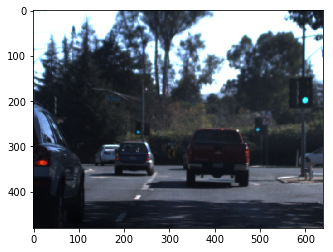

[ 0.80000028]
(20, 480, 640, 3)
(20, 1)


In [11]:
# testing the generator
training_gen = generate_train_batch(steering_labels, 20)
batch_img, steering_angle = next(training_gen)

for i in range(1):
    im = np.array(batch_img[i], dtype=np.uint8)
    steering = steering_angle[i]
    plt.imshow(im)
    plt.show();
    print(steering)
    
print(batch_img.shape)
print(steering_angle.shape)

In [9]:
# frame size
nrows = 480
ncols = 640

# model start here
model = Sequential()

model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', input_shape=(480, 640, 3)))
model.add(BatchNormalization(epsilon=0.001, axis=1))
model.add(Conv2D(12,(5,5),padding='valid', activation='relu', strides=(2,2)))
model.add(Conv2D(12,(5,5),padding='valid', activation='relu', strides=(2,2)))
model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
model.add(Conv2D(24,(3,3),padding='valid', activation='relu', strides=(1,1)))
model.add(Conv2D(48,(3,3),padding='valid', activation='relu', strides=(1,1)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation=None))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 240, 320, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 320, 3)       960       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 12)      912       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 12)        3612      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 37, 24)        7224      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 35, 24)        5208      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 33, 48)        10416     
__________

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

In [ ]:
from keras.models import load_model
adam = Adam(lr=0.0001)
model.compile(loss=root_mean_squared_error,
              optimizer=adam,
              metrics=["accuracy"])


model.save('my_model.h5')

In [ ]:
generator = generate_train_batch(steering_labels, 1)
history = model.fit_generator(generator, steps_per_epoch=10000, epochs=5, verbose=1)

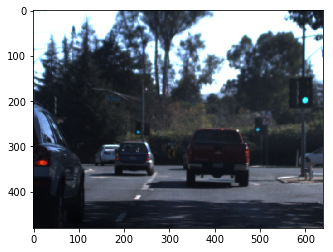

[ 0.80000028]
[ 0.90048426]


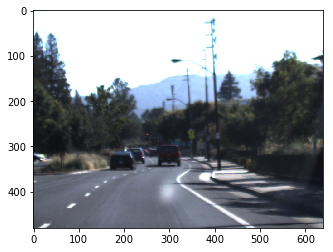

[ 0.90000037]
[ 1.75957084]


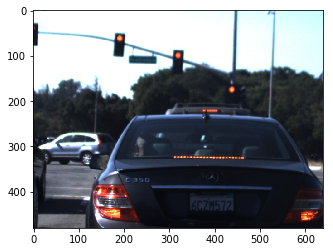

[ 6.80000259]
[ 4.89403296]


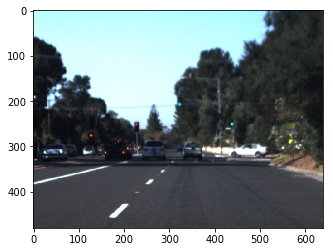

[ 1.40000049]
[ 2.67759705]


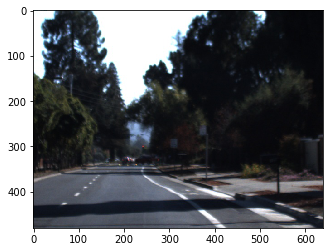

[ 9.3067129]
[ 4.08551359]


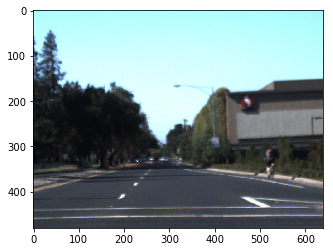

[ 6.16863319]
[ 3.79354215]


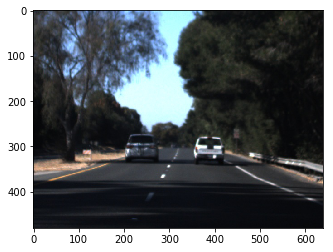

[ 1.86808192]
[ 0.81517881]


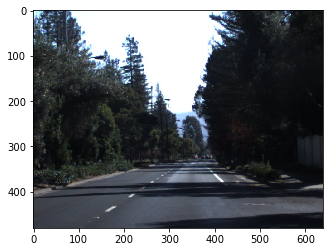

[ 1.70000065]
[ 1.48644555]


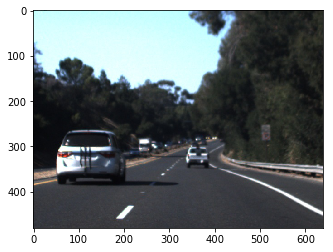

[ 2.50000082]
[ 1.64750862]


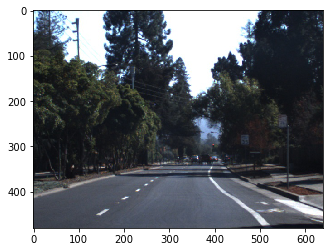

[ 5.20000203]
[ 4.29209423]


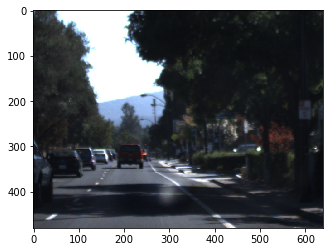

[ 1.00000035]
[-20.86822319]


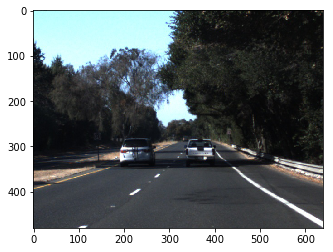

[ 1.00000035]
[ 1.615955]


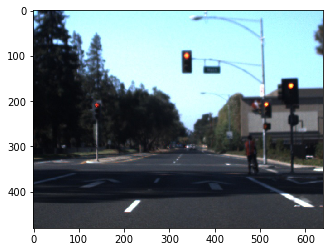

[ 2.0000007]
[ 2.19712138]


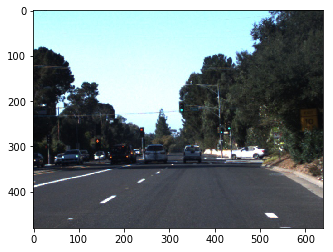

[ 1.95651605]
[ 2.50834656]


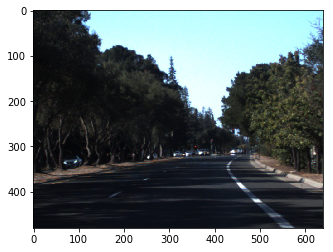

[-0.20000007]
[-0.00735451]


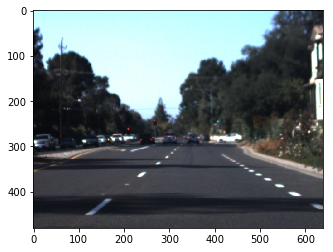

[ 1.2775956]
[ 1.13037574]


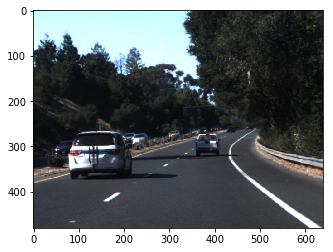

[ 0.433097]
[ 0.50151527]


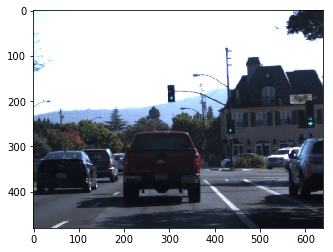

[ 4.39627505]
[ 2.94399428]


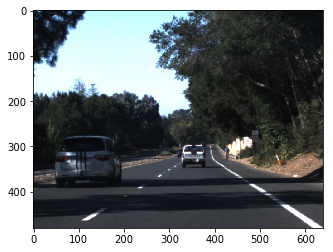

[ 1.40000049]
[ 1.61831343]


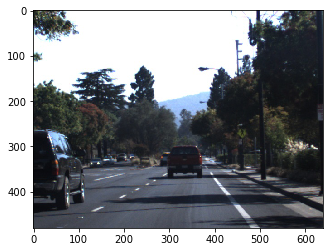

[ 1.70000065]
[ 1.66960585]


In [12]:
# testing the results
model.load_weights('trained.h5')
predictions = model.predict(batch_img)

for i in range(20):
    im = np.array(batch_img[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show();
    print(steering_angle[i])
    print(predictions[i])
#model.save('trained.h5')